In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from lib.optimizers import *
from lib.functions import *
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## Example functions

$$p \in \R^N = \R^3, \forall_{0 \leq i < M} \, x^{[i]} \in \R^K = \R^2, \, y^{[i]} \in \R$$

$$f : \R^K \times \R^N \to \R, \qquad f(x, p) = p_0 x_0 + p_1 x_1 + p_2 $$

$$ D_pf(x, p) = \left[\frac{\partial f}{\partial p_0}(x, p), \frac{\partial f}{\partial p_1}(x, p), \frac{\partial f}{\partial p_2}(x, p)\right]^T = [x_0, x_1, 1]^T$$

$$ R : \R^N \to \R^M, \qquad R(p) = \left[f(x^{[i]}, p) - y^{[i]}\right]_{0 \leq i < M} $$

$$ D_pR(p) = \left[2(f(x^{[i]}, p) - y^{[i]})\frac{\partial f}{\partial p_j}(x^{[i]}, p)\right]_{0 \leq i < M, 0 \leq j < N}$$

In [ ]:
xs = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
ys = np.array([1, 2, 3, 4])


def f(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return p[0] * x[0] + p[1] * x[1] + p[2]


def df(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    assert x.shape == (2,)
    assert p.shape == (3,)

    return np.array([x[0], x[1], 1])


def residue(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    xs: np.ndarray,
    ys: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])

    return (fs - ys)**2


def residue_jacobian(
    f: Callable[[np.ndarray, np.ndarray], np.ndarray],
    df: Callable[[np.ndarray, np.ndarray], np.ndarray],
    ys: np.ndarray,
    xs: np.ndarray,
    p: np.ndarray,
) -> np.ndarray:
    assert xs.shape[1] == 2
    assert xs.shape[0] == ys.shape[0]
    assert p.shape == (3,)

    fs = np.array([f(x, p) for x in xs])
    dfs = np.array([df(x, p) for x in xs])

    return np.array([2 * (fs[i] - ys[i]) * dfs[i] for i in range(len(xs))])

In [ ]:
def R_value(p: np.ndarray) -> np.ndarray:
    return residue(f, xs, ys, p)

def R_derivative(p: np.ndarray) -> np.ndarray:
    return residue_jacobian(f, df, ys, xs, p)

R = Function(R_value, R_derivative, 3, 4)

In [ ]:
R_value(np.array([1, 1, 1]))

array([ 9, 16, 25, 36])

## Example function

$$ M = 8, N = 12, F : \R^M \to \R^N$$

$$ F(x) = \begin{bmatrix}
    \sin(x_1) + \cos(2x_1) \\
    \cos(-2x_2 + 1) \\
    2 \exp(x_3) \\
    \exp(\sin(||x||_2)) \\
    \left(\exp\left(1 + \sum_{i=1}^{M} x_i\right)\right)^2 \\
    \cos(\exp(\sin^2(x_5))) \\
    \left(\sin\left(\sqrt{|\sum_{i=1}^M x_i|} - 1\right)\right)^2 \\
    \sqrt{\sin(\prod_{i=1}^M x_i) + 2} \\
    \left|\prod_{i=1}^M x_i\right| + 1 \\
    \sin(x_1) + \cos(x_2) + \exp(x_3) + x_4^2 + |x_5| + \sqrt{|x_6|} + \sin^2(x_7) + \sqrt{|\cos(\exp(\sin(x_8)))|} \\
    \sin(||x||_2) + \cos(||x||_2) - \exp\left(\sum_{i=1}^M x_i\right) \\
    ||x||_2^2
\end{bmatrix}$$

In [ ]:
M = 8
sin = Function(F=np.sin, DF=np.cos, M=1, N=1)
cos = Function(F=np.cos, DF=lambda x: -np.sin(x), M=1, N=1)
exp = Function(F=np.exp, DF=np.exp, M=1, N=1)
square = Function(F=lambda x: x**2, DF=lambda x: 2 * x, M=1, N=1)
abs = Function(F=np.abs, DF=lambda x: np.sign(x), M=1, N=1)
sqrt = Function(F=lambda x: np.sqrt(np.abs(x)), DF=lambda x: 0.5 / np.sqrt(np.abs(x)) * np.sign(x), M=1, N=1)
norm = Function(F=np.linalg.norm, DF=lambda x: x / np.linalg.norm(x), M=M, N=1)
sum_ = Function(F=np.sum, DF=lambda _: np.ones(M), M=M, N=1)
mul_ = Function(F=lambda x: np.array(np.prod(x)), DF=lambda x: np.prod(x) / x, M=M, N=1)
proj = lambda k: Function(F=lambda x: x[k], DF=lambda _: np.eye(M)[k], M=M, N=1)
constM = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(M), M=M, N=1)
const1 = lambda c: Function(F=lambda _: np.array(c), DF=lambda _: np.zeros(1), M=1, N=1)
mul_const = lambda c: Function(F=lambda x: c * x, DF=lambda _: np.array(c), M=1, N=1)

F1 = compose(proj(0), sin + compose(mul_const(2), cos))
F2 = compose(proj(1), mul_const(-2) + const1(1), cos)
F3 = compose(proj(2), 2 * exp)
F4 = compose(norm, sin, exp)
F5 = compose(sum_ + constM(1), exp, square)
F6 = compose(proj(5), sin, square, exp, cos)
F7 = compose(sum_, sqrt - const1(1), sin, square)
F8 = compose(mul_, sin + const1(2), sqrt)
F9 = compose(mul_, abs + const1(1))
F10 = (
    compose(proj(0), sin) + compose(proj(1), cos) + compose(proj(2), exp) + compose(proj(3), square) + compose(proj(4), abs) 
    + compose(proj(5), sqrt) + compose(proj(6), sin, square) + compose(proj(7), sin, exp, cos, sqrt)
)
F11 = compose(norm, sin + cos) - compose(sum_, exp)
F12 = compose(norm, square)
F = stack(F1, F2, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12)

p = np.array([np.pi / 3, - np.pi / 5, -4, 3, -1, 5, 2, 3])
print(F(p))
print(F.differential(p))

[ 3.66025404e-01 -6.33323869e-01  3.66312778e-02  2.64229397e+00
  1.51751981e+08 -8.05980153e-01  8.94545580e-01  1.71735764e+00
  2.37870506e+02  1.53942607e+01 -4.53108532e+03  6.54914069e+01]
[[-1.23205081e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.54777373e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.66312778e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-8.08403412e-02  4.85042047e-02  3.08787358e-01 -2.31590518e-01
   7.71968394e-02 -3.85984197e-01 -1.54393679e-01 -2.31590518e-01]
 [ 3.03503962e+08  3.03503962e+08  3.03503962e+08  3.03503962e+08
   3.03503962e+08  3.03503962e+08  3.03503962e+08  3.03503962e+08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  8.07689852e-01  0.00000000e+00  0.00000000e+00]
 [-1.0

In [ ]:
p0 = np.random.rand(M)
max_iter = 10000
p0

array([0.44951916, 0.11116981, 0.32658987, 0.53926165, 0.25967183,
       0.4901192 , 0.97319733, 0.74383574])

In [ ]:
p, err = gradient_descent(F, p0, 1e-10, max_iter)
p, err

(array([-0.32792474, -0.78128237, -1.07826589, -0.18825569, -0.34086606,
        -0.17294264, -0.80879397, -0.40463633]),
 5.4634314084027)

In [ ]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=1e-10, step_type="solve", silent=False)
p, err

Singular matrix encountered in 1-th iteration. Returning current point.


(array([0.44951916, 0.11116981, 0.32658987, 0.53926187, 0.25967175,
        0.4901192 , 0.97319737, 0.74383555]),
 17796.06987292182)

In [ ]:
p, err = gauss_newton(R=F, p0=p0, max_iter=max_iter, alpha=1e-3, step_type="least_squares", silent=False)
p, err

iter 0: p = [0.44951916 0.11116981 0.32658987 0.53926165 0.25967183 0.4901192
 0.97319733 0.74383574], ||F(p)|| = 17796.069874701447
DR(p) rank = 8, DR(p).T @ DR(p) rank = 7
iter 1: p = [ 0.45110895  0.12012797  0.32558987  5.03859713 -1.22794712  0.4904418
  1.85333181 -3.15838583], ||F(p)|| = 17778.356755222427
DR(p) rank = 8, DR(p).T @ DR(p) rank = 8
iter 2: p = [ 0.45268613  0.12841235  0.32458987  5.04341144 -1.14911161  0.49076382
  1.80480403 -3.20319144], ||F(p)|| = 17760.587339653885
DR(p) rank = 8, DR(p).T @ DR(p) rank = 8
iter 3: p = [ 0.454251    0.13615691  0.32358987  5.04695544 -1.08615263  0.49108525
  1.76312058 -3.23714184], ||F(p)|| = 17742.83567852034
DR(p) rank = 8, DR(p).T @ DR(p) rank = 8
iter 4: p = [ 0.45580384  0.14345594  0.32258987  5.04960796 -1.03410388  0.49140611
  1.72653506 -3.26393029], ||F(p)|| = 17725.10175689563
DR(p) rank = 8, DR(p).T @ DR(p) rank = 8
iter 5: p = [ 0.4573449   0.15037883  0.32158987  5.0515971  -0.98998376  0.49172638
  1.69389961

KeyboardInterrupt: 

In [ ]:
p = np.array([ 1.48813909e+00,  1.56120223e+00, -4.31041013e+00,  8.09115693e-01,
 -7.86759647e-05,  7.34942470e-01,  8.22141735e-01,  4.69645535e-01])
# p = np.array([ 1.48809762e+00,  1.56119263e+00, -4.30941013e+00,  7.21511599e-01,
#   1.21195404e-04,  7.34940504e-01,  9.10653915e-01,  4.68090866e-01])
np.linalg.norm(F(p)), np.linalg.norm(F.differential(p)), np.linalg.norm(np.linalg.lstsq(F.differential(p), F(p), rcond=None)[0])

(174.30041429839238, 975.1476792403906, 4997447.895347811)

In [ ]:
optimizer = LevenbergMarquardt(
    R=F, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=0.01, lambda_change=1.1)
)

In [ ]:
p, err = optimizer.optimize(p0=p0, max_iter=max_iter, step_type="solve")
p, err

(array([-4.80229002e-01, -1.80296797e-01, -5.72662708e-01, -6.67337934e-02,
        -9.13302171e-05, -9.47124742e-04, -6.67809796e-02,  1.65214628e-01]),
 3.8481748883827684)

In [ ]:
p, err = optimizer.optimize(p0=p0, max_iter=max_iter, step_type="least_squares")
p, err

(array([-5.02794959e-01, -3.83878575e-02, -6.06714208e-01, -7.96398926e-02,
        -9.38165521e-03,  3.17549252e-04, -7.97128428e-02,  1.76024058e-01]),
 3.8616548461545004)

In [ ]:
p, err = optimizer.optimize(p0=p0, max_iter=max_iter, step_type="ridge")
p, err

(array([-4.81366914e-01, -9.67591880e-02, -6.26775551e-01, -4.13787189e-02,
         1.98514923e-06,  1.99276300e-04, -4.15246289e-02,  7.05311031e-02]),
 3.8570046391965516)

## Hyperparameters

In [ ]:
# p0 = np.random.randn(3)
p0 = np.array([1.5, 0.6, -3.14])
max_iter = 1000

## Gradient descent method

In [ ]:
p, err = gradient_descent(R, p0, 0.0001, max_iter)
print(f"{p=}, {err=}")

p=array([ 1.12693716,  0.63955052, -2.72738664]), err=2.0158093579792693


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([-0.32134843,  1.44513925,  3.21162694,  4.97811462])

## Gauss-Newton method

In [ ]:
p, err = gauss_newton(R, p0, max_iter, silent=True)
print(f"{p=}, {err=}")

Singular matrix encountered in 5-th iteration. Returning current point.
p=array([ 0.82308036,  0.21129464, -0.29066964]), err=0.003980691350191393


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([0.955   , 1.989375, 3.02375 , 4.058125])

## Levenberg-Marquardt method

#### 1. Constant $\lambda_k$ sequence

In [ ]:
lambda_param = 1e-3
optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)
p, err = optimizer.optimize(p0, max_iter)
print(f"{p=}, {err=}")

p=array([-0.07937187,  1.07977078, -1.08085736]), err=5.463312677507736e-07


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([0.99931233, 1.99971123, 3.00011014, 4.00050904])

In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([-0.07937187,  1.07977078, -1.08085736]), err=5.463312677507736e-07


In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
print(f"{p=}, {err=}")

p=array([-0.07647219,  1.07871259, -1.08481522]), err=1.7233163951545136e-05


### Test parameters

In [ ]:
lambda_params = [10**i for i in range(-10, 2)]
errors_levenberg_marquardt_constant_param = []
p0s = [np.random.randn(3) for _ in range(10)]

for lambda_param in lambda_params:
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, silent=True)
        errs.append(err)
    
    errors_levenberg_marquardt_constant_param.append(errs)

errors_gauss_newton = []
for p0 in p0s:
    p, err = gauss_newton(R=R, p0=p0, max_iter=max_iter, silent=True)
    errors_gauss_newton.append(err)

Singular matrix encountered in 15-th iteration. Returning current point.
Singular matrix encountered in 5-th iteration. Returning current point.
Singular matrix encountered in 4-th iteration. Returning current point.
Singular matrix encountered in 32-th iteration. Returning current point.
Singular matrix encountered in 42-th iteration. Returning current point.
Singular matrix encountered in 11-th iteration. Returning current point.
Singular matrix encountered in 0-th iteration. Returning current point.
Singular matrix encountered in 14-th iteration. Returning current point.
Singular matrix encountered in 34-th iteration. Returning current point.
Singular matrix encountered in 8-th iteration. Returning current point.


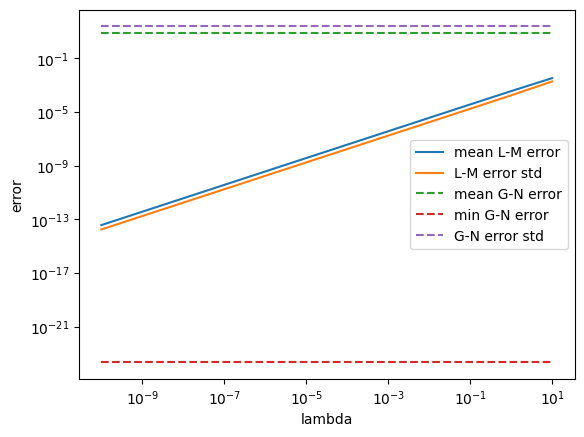

In [ ]:
errors_mean = np.mean(errors_levenberg_marquardt_constant_param, axis=1)
errors_std = np.std(errors_levenberg_marquardt_constant_param, axis=1)

errors_gn_mean = np.mean(errors_gauss_newton)
errors_gn_std = np.std(errors_gauss_newton)

plt.loglog(lambda_params, errors_mean, label="mean L-M error")
plt.loglog(lambda_params, errors_std, label="L-M error std")

plt.loglog(lambda_params, [errors_gn_mean] * len(lambda_params), label="mean G-N error", linestyle="--")
plt.loglog(lambda_params, [np.min(errors_gauss_newton)] * len(lambda_params), label="min G-N error", linestyle="--")
plt.loglog(lambda_params, [errors_gn_std] * len(lambda_params), label="G-N error std", linestyle="--")

plt.legend()
plt.xlabel("lambda")
plt.ylabel("error")
plt.show()

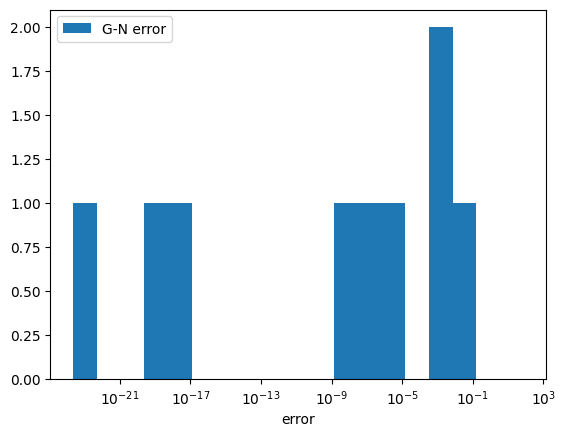

In [ ]:
logbins = np.logspace(np.log10(np.min(errors_gauss_newton)), np.log10(np.max(errors_gauss_newton)), 20)
plt.hist(errors_gauss_newton, bins=logbins, label="G-N error")
plt.xscale("log")
plt.xlabel("error")
plt.legend()
plt.show()

#### 2. Sequence $\lambda_k$ decrasing when error is decreasing, and increasing otherwise

In [ ]:
optimizer = LevenbergMarquardt(
    R=R,
    lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(
        lambda0=0.1, lambda_change=2
    ),
)
p, err = optimizer.optimize(p0, max_iter)
print(f"{p=}, {err=}")

p=array([ 0.03282742,  0.96717258, -0.96717258]), err=5.0697667660620786e-20


In [ ]:
np.array([f(xs[i], p) for i in range(len(xs))])

array([1., 2., 3., 4.])

In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="least_squares")
print(f"{p=}, {err=}")

p=array([ 0.03282742,  0.96717258, -0.96717258]), err=1.9968781409166757e-20


In [ ]:
p, err = optimizer.optimize(p0, max_iter, step_type="ridge")
print(f"{p=}, {err=}")

p=array([ 0.03284614,  0.96715308, -0.96715095]), err=2.107187031123506e-12
